In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.ticker import FuncFormatter
from typing import Any , Literal , Optional

from src.factor.util.plot import CURRENT_SEABORN_VERSION , multi_factor_plot , plot_head , plot_tail , plot_table

df = pd.read_excel('d:/Coding/learndl/learndl/model/ple_gru_day_ShortTest/analysis_of_0_best/data.xlsx' , 'factor_grp_curve')

In [36]:
df

,date,group,factor_name,group_ret,start,end,benchmark
0,20170104,group1,ple_gru@best,-0.080943,20170106,20170119,default
1,20170104,group2,ple_gru@best,-0.072030,20170106,20170119,default
2,20170104,group3,ple_gru@best,-0.067808,20170106,20170119,default
3,20170104,group4,ple_gru@best,-0.072808,20170106,20170119,default
4,20170104,group5,ple_gru@best,-0.064794,20170106,20170119,default
...,...,...,...,...,...,...,...
345,20170222,group6,ple_gru@best,0.003389,20170224,20170309,csi1000
346,20170222,group7,ple_gru@best,0.013233,20170224,20170309,csi1000
347,20170222,group8,ple_gru@best,0.009794,20170224,20170309,csi1000
348,20170222,group9,ple_gru@best,0.013764,20170224,20170309,csi1000


In [37]:
factor_name = 'ple_gru@best'
benchmark = 'default'
df , fig = plot_head(df , factor_name , benchmark)

<Figure size 1600x700 with 0 Axes>

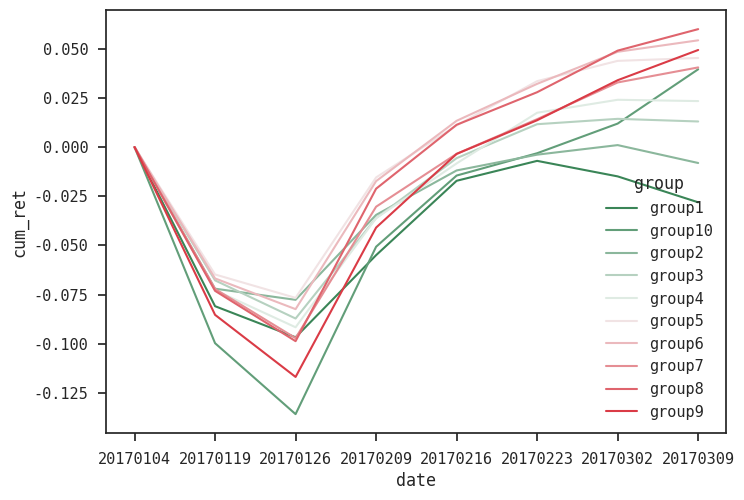

In [29]:
df = df.set_index('date')
if CURRENT_SEABORN_VERSION:
    ax = sns.lineplot(x='date', y='cum_ret', hue='group', data=df,
                        palette=sns.diverging_palette(140, 10, sep=10, n=df['group'].nunique()))
else:
    ax = sns.lineplot(x='date', y='cum_ret', hue='group', data=df)

In [47]:
df = pd.DataFrame()
df1 = pd.DataFrame({'date' :[1] , 'model_num':[0] , 'model_type':['a'] , 'value':[3.5]})
pd.concat([df,df1])

,date,model_num,model_type,value
0,1,0,a,3.5


In [ ]:
import os , time
import numpy as np
import pandas as pd

from IPython.display import display
from dataclasses import asdict , dataclass , field
from typing import Any , Callable , ClassVar , Optional

from src.nn_model.callback.base import CallBack
from src.nn_model.util.loader import LoaderWrapper
from src.env import PATH

class CallbackTimer(CallBack):
    '''record time cost of callback hooks'''
    def __init__(self , model_module , verbosity = 2) -> None:
        super().__init__(model_module , with_cb=True)
        self._verbosity = verbosity
        self._hook_times : dict[str,list]  = {}
        self._start_time : dict[str,float] = {}
    def at_enter(self , hook_name):
        if self._verbosity >= 10:
            self._start_time[hook_name] = time.time()
    def at_exit(self, hook_name):
        if self._verbosity >= 10:
            if hook_name not in self._hook_times.keys(): self._hook_times[hook_name] = []
            self._hook_times[hook_name].append(time.time() - self._start_time[hook_name])
            self.__getattribute__(hook_name)()
    def on_summarize_model(self):
        if self._verbosity >= 10:
            columns = ['hook_name' , 'num_calls', 'total_time' , 'avg_time']
            values  = [[k , len(v) , np.sum(v) , np.mean(v)] for k,v in self._hook_times.items()]
            print(pd.DataFrame(values , columns = columns).sort_values(by=['total_time'],ascending=False).head(5))

class BatchDisplay(CallBack):
    '''display batch progress bar'''
    def __init__(self , model_module , verbosity = 2) -> None:
        super().__init__(model_module , with_cb=False)
        self._verbosity = verbosity
    @property
    def _dl(self) -> LoaderWrapper | Any: return self.module.dataloader
    def _init_tqdm(self , text : str): 
        if self._verbosity >= 10 and isinstance(self._dl, LoaderWrapper): self._dl.init_tqdm(text)
    def _display(self , *args , **kwargs): 
        if self._verbosity >= 10 and isinstance(self._dl, LoaderWrapper): self._dl.display(*args , **kwargs)

    def on_train_epoch_start(self):      self._init_tqdm('Train Ep#{:3d} loss : {:.5f}')
    def on_train_batch_end(self):        self._display(self.status.epoch, self.metrics.output.loss_item)
    
    def on_validation_epoch_start(self): self._init_tqdm('Valid Ep#{:3d} score : {:.5f}')
    def on_validation_batch_end(self):   self._display(self.status.epoch, self.metrics.output.score)
    
    def on_test_model_type_start(self):  self._init_tqdm('Test {} {} score : {:.5f}')
    def on_test_batch_end(self):         self._display(self.status.model_type , 
                                                       self.module.batch_dates[self.module.batch_idx] , 
                                                       self.metrics.output.score)
class StatusDisplay(CallBack):
    '''display epoch and event information'''
    RESULT_PATH = f'{PATH.result}/model_results.yaml'

    def __init__(self , model_module , verbosity = 2):
        super().__init__(model_module , with_cb=False)
        self._verbosity = verbosity
        self._init_time = time.time()
        os.makedirs(os.path.dirname(self.RESULT_PATH) , exist_ok=True)
        self._times : dict[str,float] = {}
        self._texts : dict[str,str]   = {}
        self._epoch_model : int = 0
        self._epoch_stage : int = 0
        self._model_stage : int = 0
        self._test_record = self.TestRecord()
    
    @property
    def _initial_models(self) -> bool: return self._model_stage <= self.config.model_num
    @property
    def _model_test_dates(self) -> np.ndarray: return self.module.data.model_test_dates
    @property
    def _speedup2x(self) -> bool:
        try:
            return self.config.train_param['callbacks']['ResetOptimizer']['speedup2x']
        except KeyError:
            return False
    def _display(self , *args , **kwargs):
        return self.logger.info(*args , **kwargs) if (self._verbosity > 2 or self._initial_models) else self.logger.debug(*args , **kwargs)
    def event_sdout(self , event) -> str:
        if event == 'reset_learn_rate':
            sdout = f'Reset learn rate and scheduler at the end of epoch {self.status.epoch} , effective at epoch {self.status.epoch + 1}'
            if self._speedup2x: sdout += ', and will speedup2x'
        elif event == 'new_attempt':
            sdout = '{attempt} {epoch} : {status}, Next attempt goes!'.format(**self._texts)
        elif event == 'nanloss':
            sdout = 'Model {model_date}.{model_num} Attempt{attempt}, epoch{epoch} got nanloss!'.format(**asdict(self.status))
        else:
            raise KeyError(event)
        return sdout
    def update_test_score(self):
        self._test_record.update_score(self.status.model_num , self.status.model_type , self.metrics.scores[-len(self._model_test_dates):] ,
                                       self.status.model_date , self._model_test_dates)

    def tic(self , key : str): self._times[key] = time.time()
    def toc(self , key : str): return time.time() - self._times[key]
    def tic_str(self , key : str):
        self.tic(key)
        return 'Start Process [{}] at {:s}!'.format(key.capitalize() , time.ctime(self._times[key]))
    def toc_str(self , key : str , avg = False): 
        toc = self.toc(key)
        if avg and self._model_stage * self._epoch_stage:
            self._texts[key] = 'Finish Process [{}], Cost {:.1f} Hours, {:.1f} Min/model, {:.1f} Sec/Epoch'.format(
                key.capitalize() , toc / 3600 , toc / 60 / self._model_stage , toc / self._epoch_stage)
        else:
            self._texts[key] = 'Finish Process [{}], Cost {:.1f} Secs'.format(key.capitalize() , toc)
        return self._texts[f'{key}']

    # callbacks
    def on_configure_model(self):
        self.logger.warning('Model Specifics:')
        self.config.print_out()
    def on_summarize_model(self):
        result = {
            '0_model' : f'{self.config.model_name}(x{len(self.config.model_num_list)})',
            '1_start' : time.ctime(self._init_time) ,
            '2_basic' : 'short' if self.config.short_test else 'full' , 
            '3_datas' : self.config.model_data_type ,
            '4_label' : ','.join(self.config.labels),
            '5_dates' : '-'.join([str(self.config.beg_date),str(self.config.end_date)]),
            '6_fit'   : self._texts.get('fit'),
            '7_test'  : self._texts.get('test'),
            '8_result': self._test_record.test_scores,
        }
        PATH.dump_yaml(result , self.RESULT_PATH)

    def on_data_start(self):    self.logger.critical(self.tic_str('data'))
    def on_data_end(self):      self.logger.critical(self.toc_str('data'))
    def on_fit_start(self):     self.logger.critical(self.tic_str('fit'))
    def on_fit_end(self):       self.logger.critical(self.toc_str('fit' , avg=True))

    def on_fit_model_start(self):
        self.tic('model')
        self._model_stage += 1
        self._epoch_model = 0
        self._texts = {k:'' for k in ['model','attempt','epoch','epoch_model','status','time','exit']}
        self._texts['model'] = '{:s} #{:d} @{:4d}'.format(self.config.model_name , self.status.model_num , self.status.model_date)
    def on_fit_epoch_start(self):
        self._epoch_model += 1
        self._epoch_stage += 1
        self._texts['epoch'] = 'Ep#{:3d}'.format(self.status.epoch)
        self._texts['epoch_model'] = 'Ep#{:3d}'.format(self._epoch_model)
        self._texts['attempt'] = f'FirstBite' if self.status.attempt == 0 else f'Retrain#{self.status.attempt}'
    def on_validation_epoch_end(self):
        if self.module.status.epoch < 0: return
        self._texts['status'] = 'loss {: .5f}, train{: .5f}, valid{: .5f}, best{: .4f}, lr{:.1e}'.format(
            self.metrics.latest['train.loss'], self.metrics.latest['train.score'] ,
            self.metrics.latest['valid.score'] , self.metrics.best_metric , 
            self.module.optimizer.last_lr)
        if self.status.epoch % [10,5,5,3,3,1][min(self._verbosity // 2 , 5)] == 0: 
            self._display('{attempt} {epoch} : {status}'.format(**self._texts))
    def on_fit_epoch_end(self):
        if self.status.end_of_loop: self._texts['exit'] = self.status.end_of_loop.trigger_reason
        while self.status.epoch_event: self._display(self.event_sdout(self.status.epoch_event.pop()))
    def on_fit_model_end(self):
        train_score = self.metrics.latest.get('train.score' , 0)
        valid_score = self.metrics.latest.get('valid.score' , 0)
        best_score = self.status.best_attempt_metric if self.status.best_attempt_metric else valid_score
        self._texts['status'] = f'Train{train_score: .4f} Valid{valid_score: .4f} BestVal{best_score: .4f}'
        self._texts['time'] = 'Cost{:5.1f}Min,{:5.1f}Sec/Ep'.format(
            self.toc('model') / 60 , self.toc('model') / (self._epoch_model + 1))
        self.logger.warning('{model}|{attempt} {epoch_model} {exit}|{status}|{time}'.format(**self._texts))
    def on_test_start(self): 
        self.logger.critical(self.tic_str('test'))
        self.logger.warning('Each Model Date Testing Mean Score({}):'.format(self.config.train_param['criterion']['score']))
        self._test_record = self.TestRecord(self.config.model_num_list , self.config.model_types , self.logger.info)
        # self._test_record.print_colnames()

    def on_test_model_type_end(self):
        self.update_test_score()

    def on_test_model_end(self):
        if self.status.model_num == self._test_record.model_nums[-1]: self._test_record.print_score()

    def on_test_end(self): 
        for model_num in self.config.model_num_list:
            path = self.config.model_param[model_num]['path'] + f'/{self.config.model_name}_score_by_date_{model_num}.csv'
            self._test_record.score_table(model_num , path)
        self._test_record.summarize().to_csv(f'{self.config.model_base_path}/{self.config.model_name}_score_by_model.csv')
        self._test_record.print_summary()
        self.logger.critical(self.toc_str('test'))

    @dataclass
    class TestRecord:
        model_nums : list  = field(default_factory=list)
        model_types : list = field(default_factory=list)
        printer : Callable = print

        SUMMARY_ADDROWS : ClassVar[dict[str,str]] = {'Avg':'AllTimeAvg','Sum':'AllTimeSum','Std':'Std','T':'TValue','IR':'AnnIR'}
        SUMMARY_NDIGITS : ClassVar[dict[str,int]] = {'Avg':4,'Sum':2,'Std':4,'T':2,'IR':4}

        def __post_init__(self):
            self.n_num = len(self.model_nums)
            self.n_type = len(self.model_types)
            self.n_col = self.n_num * self.n_type
            self.col_num  = np.repeat(self.model_nums , self.n_type).astype(str)
            self.col_type = np.tile(self.model_types , self.n_num).astype(str)
            self.col_summary = [f'{mn}.{mt}' for mn,mt in zip(self.col_num , self.col_type)]

            self.n_date  = 0
            self.n_model = 0
            self.row_date  = np.array([]).astype(int)
            self.row_model = np.array([]).astype(int)
            self.score_by_date  = np.empty((self.n_date , self.n_col))
            self.score_by_model = np.empty((self.n_model, self.n_col))

            self.df_date = pd.DataFrame()
            self.df_model = pd.DataFrame()

        def add_rows(self , model , dates):
            if isinstance(model , int): model = [model]
            self.n_date += len(dates)
            self.n_model += 1
            self.row_date  = np.concatenate([self.row_date  , dates])
            self.row_model = np.concatenate([self.row_model  , [model]])
            self.score_by_date  = np.concatenate([self.score_by_date  , np.zeros((len(dates) , self.n_col))])
            self.score_by_model = np.concatenate([self.score_by_model , np.zeros((1 , self.n_col))])

        def update_score(self , model_num , model_type , scores , model_date , test_dates):
            col = model_num * self.n_type + self.model_types.index(model_type)
            self.score_by_date[-len(scores):, col] = np.nan_to_num(scores)
            self.score_by_model[-1,col] = np.nanmean(scores)
            df_date = pd.DataFrame({
                'model_num' : model_num , 'model_type' : model_type , 'model_date' : model_date ,
                'date' : test_dates , 'value' : scores
            })
            df_model = df_date.groupby(['model_date' , 'model_num','model_type'])['value'].mean().reset_index()
            df_model['model_date'] = df_model['model_date'].astype(str)
            self.df_date = pd.concat([self.df_date , df_date])
            self.df_model = pd.concat([self.df_model , df_model])
    
        def summarize(self):
            self.summary : dict[str,np.ndarray] = {
                'Avg' : (score_mean := np.nanmean(self.score_by_date , axis = 0)) , 
                'Sum' : np.nansum(self.score_by_date  , axis = 0) , 
                'Std' : (score_std  := np.nanstd(self.score_by_date  , axis = 0)), 
                'T'   : score_mean / score_std * (len(self.score_by_date)**0.5), 
                'IR'  : score_mean / score_std * ((240 / 10)**0.5) ,
            }
            values = np.concatenate([self.score_by_model , np.stack(list(self.summary.values()))])
            index  = [str(d) for d in self.row_model] + [self.SUMMARY_ADDROWS[k] for k in self.summary.keys()]


            df_avg = self.df_date.groupby(['model_num','model_type'])['value'].mean()#.reset_index().assign(model_date = 'Avg')
            df_sum = self.df_date.groupby(['model_num','model_type'])['value'].sum()#.reset_index().assign(model_date = 'Sum')
            df_std = self.df_date.groupby(['model_num','model_type'])['value'].std()#.reset_index().assign(model_date = 'Std')

            df_tv = (df_avg / df_std) * (len(self.df_date['date'].unique())**0.5)
            df_ir = (df_avg / df_std) * ((240 / 10)**0.5)
            self.df_model = pd.concat([
                self.df_model , 
                df_avg.reset_index().assign(model_date = 'Avg') ,
                df_sum.reset_index().assign(model_date = 'Sum') , 
                df_std.reset_index().assign(model_date = 'Std') ,
                df_tv.reset_index().assign(model_date = 'T') , 
                df_ir.reset_index().assign(model_date = 'IR') ,
            ])

            return pd.DataFrame(values , index = index , columns = self.col_summary)

        def print_colnames(self):
            #self.print_row('Models' , self.col_num)
            #self.print_row('Output' , self.col_type)
            ...

        def print_score(self):
            #self.print_row(self.row_model[-1] , self.score_by_model[-1,:] , 4)
            ...

        def print_summary(self):
            display(self.df_model)
            #[self.print_row(self.SUMMARY_ADDROWS[k],v,self.SUMMARY_NDIGITS[k]) for k,v in self.summary.items()]

        def print_row(self , row , values , digit = 2):
            fmt = 's' if isinstance(values[0] , str) else (f'd' if digit == 0 else f'.{digit}f')
            self.printer(('{: <11s}'+('{: >8'+fmt+'}')*len(values)).format(str(row) , *values))

        def score_table(self , model_num , save_to : Optional[str] = None):
            df = pd.DataFrame({'dates' : self.row_date} , 
                                index = list(map(lambda x:f'{x[:4]}-{x[4:6]}-{x[6:]}' , self.row_date.astype(str))))
            for i , model_type in enumerate(self.model_types):
                df[f'score.{model_type}'] = self.score_by_date[:,model_num * self.n_type  + i]
                df[f'cum_score.{model_type}'] = np.nancumsum(self.score_by_date[:,model_num * self.n_type  + i])

            if save_to: df.to_csv(save_to)
            return df
        
        @property
        def test_scores(self):
            if not hasattr(self , 'summary'): return
            return {col:'|'.join([f'{k}({round(v[i],self.SUMMARY_NDIGITS[k])})' for k,v in self.summary.items()]) 
                    for i , col in enumerate(self.col_summary)}

In [30]:
df

,group,cum_ret
date,,
20170104,group1,0.000000
20170104,group10,0.000000
20170104,group2,0.000000
20170104,group3,0.000000
20170104,group4,0.000000
...,...,...
20170309,group6,0.054340
20170309,group7,0.040543
20170309,group8,0.060027


In [27]:
df_0

,group,date,group_ret
0,group1,20170104,0.0
1,group10,20170104,0.0
2,group2,20170104,0.0
3,group3,20170104,0.0
4,group4,20170104,0.0
5,group5,20170104,0.0
6,group6,20170104,0.0
7,group7,20170104,0.0
8,group8,20170104,0.0
9,group9,20170104,0.0


In [1]:
from typing import Literal
from src.factor.optimizer.util import SolverInput , SolveCond , SolveVars
from src.factor.optimizer.util.solver_input import LinearConstraint , BoundConstraint , CovConstraint , TurnConstraint , ShortConstraint
from src.factor.basic.var import SYMBOL_STOCK_LB , SYMBOL_STOCK_UB

input = SolverInput.rand()




In [2]:
from src.factor.optimizer.solver import MosekSolver , CvxpySolver

In [3]:
msolver = MosekSolver(input)
msolver.solve()

(array([0.2318499 , 0.54128885, 0.22686125]), True, 'optimal')